In [8]:
import cv2
import numpy as np
import numpy.fft as fft

from PIL import Image, ImageDraw, ImageFont

import matplotlib.pyplot as plt
from matplotlib import  rcParams

rcParams['font.family'] = 'monospace'
rcParams['font.monospace'] = ['Ubuntu Mono', 'JetBrains Mono', 'Consolas', 'monospace']

WATER_MARK_ALPHA = 0.04

TAMPER_LOCATE_CROP = 0.05


def text_to_img(text, img_height):
    """ 文字转图片, 字体大小填充图片高度 """
    font = ImageFont.truetype('consola', img_height)
    img_width = int(font.getlength(text))
    img = Image.new('RGB', (img_width, img_height), (0, 0, 0))
    draw = ImageDraw.Draw(img)
    draw.text((0, 0), text, font=font, fill=(255, 255, 255))
    return np.array(img)


def load_water_mark(type: str, name: str, height: int = None):
    """ 载入适合频域的水印
    如果是 type 为 text 则生成内容为 name 的图片作为水印
    如果是 type 为 image 则载入目录下名称为 name 的图片作为水印, 将图片等比缩放至高度为 height """
    if type == 'text':
        wm = text_to_img(name, height)
    elif type == 'image':
        wm = cv2.imread(name)
        if height is not None:
            wm = cv2.resize(
                wm, (int(wm.shape[1] * height / wm.shape[0]), height))
    else:
        raise Exception('type must be text or image')
    return wm


def make_water_mark(target: np.ndarray, water_mark: np.ndarray, offset: tuple = (0, 0)):
    """ 制作水印
    创建 target 大小的图片 """
    wm = np.zeros(target.shape, dtype=np.uint8)
    # 制作
    wm[-water_mark.shape[0]-offset[0]:-offset[0], - water_mark.shape[1]-offset[1]:-offset[1]] = water_mark
    wm = wm[::-1, ::-1]
    wm[-water_mark.shape[0]-offset[0]:-offset[0], - water_mark.shape[1]-offset[1]:-offset[1]] = water_mark
    wm = wm[::-1, ::-1]
    return np.uint8(wm)


def show_images(images: list, titles: list, n: int, m: int, font_scale: float = 1, dpi: int = 800):
    """ 图像显示辅助函数
    并排显示 n * m 张图像, n 行 m 列
    在每张图左侧和顶侧显示像素坐标, 在每张图顶侧显示标题 """
    plt.figure(dpi=dpi)
    # 调整文字大小
    rcParams['font.size'] = 12 * font_scale
    for i in range(n):
        for j in range(m):
            plt.subplot(n, m, i * n + j + 1)
            plt.imshow(images[i * n + j], cmap='gray')
            plt.title(titles[i * n + j])
    plt.show()


def center_log_spectrum(spectrum: np.ndarray):
    """ 频谱中心化、对数化、归一化、* 255 """
    spectrum = np.log(np.abs(spectrum) + 1)
    spectrum = (spectrum - np.min(spectrum)) * 255 // (np.max(spectrum) - np.min(spectrum))
    return np.uint8(spectrum)


def rgb_fft2(rgbImage):
    """ 对 rgb 图像分通道做 fft2, 并将高频分量移至中心 """
    if (rgbImage.__class__ == np.ndarray):
        return fft.fftshift(fft.fft2(rgbImage, axes=(0, 1)), axes=(0, 1))
    elif (rgbImage.__class__ == list):
        return [fft.fftshift(fft.fft2(i, axes=(0, 1)), axes=(0, 1)) for i in rgbImage]
    else:
        return None


def rgb_ifft2(rgbImage_fft_shift):
    if (rgbImage_fft_shift.__class__ == np.ndarray):
        ifft = fft.ifft2(fft.ifftshift(rgbImage_fft_shift, axes=(0, 1)), axes=(0, 1))
        ifft[ifft > 255] = 255
        ifft[ifft < 0] = 0
        return np.uint8(ifft.real)
    elif (rgbImage_fft_shift.__class__ == list):
        ifft = [fft.ifft2(fft.ifftshift(i, axes=(0, 1)), axes=(0, 1)) for i in rgbImage_fft_shift]
        ifft = [np.uint8(i.real) for i in ifft]
        ifft[ifft > 255] = 255
        ifft[ifft < 0] = 0
        return ifft
    else:
        return None


BLUR_SIZE = 128
block_size = (32,32,3)
# 文字转图片，字体大小填充图片高度
def text_to_img(text, img_height):
    font = ImageFont.truetype('consola', img_height)
    img_width = int(font.getlength(text))
    img = Image.new('RGB', (img_width, img_height), (0, 0, 0))
    draw = ImageDraw.Draw(img)
    draw.text((0, 0), text, font=font, fill=(255, 255, 255))
    return np.array(img)


def rgb_dct2(rgbImage:np.ndarray):
    '''
    对rgbImage作dct变换，返回数据类型为float32的频域图像
    '''
    return np.transpose([cv2.dct(np.float32(rgbImage[:,:,i])) for i in range(3)],axes=(1,2,0))
def rgb_idct2(rgbImage_dct:np.ndarray):
    '''
    对rgbImage_idct作逆dct变换，返回数据类型为uint8的空域图像
    '''
    Img_idct2 = np.transpose([cv2.idct(rgbImage_dct[:,:,i]) for i in range(3)],axes=(1,2,0))
    Img_idct2_qua = Img_idct2.copy()
    for i in range(Img_idct2_qua.shape[0]):
        for j in range(Img_idct2_qua.shape[1]):
            for k in range(Img_idct2_qua.shape[2]):
                if(Img_idct2_qua[i,j,k]>255):
                    Img_idct2_qua[i,j,k]=255
                elif(Img_idct2_qua[i,j,k]<0):
                    Img_idct2_qua[i,j,k]=0
                else:
                    Img_idct2_qua[i,j,k]=round(Img_idct2_qua[i,j,k])
    Img_idct2_qua = np.uint8(Img_idct2_qua)
    return Img_idct2_qua



def get_feature(Image:np.ndarray,block_size:tuple):
    feature = np.zeros(shape=(Image.shape[0]//block_size[0],Image.shape[1]//block_size[1],3))
    for i in range(feature.shape[0]):
        for j in range(feature.shape[1]):
            feature[i,j,:] = np.max(  Image[block_size[0]*i : block_size[0]*(i+1),block_size[1]*j : block_size[1]*(j+1),:],axis=(0,1))
    feature = np.uint8((feature - np.min(feature))*255 // (np.max(feature) - np.min(feature)))
    return feature

def differ(img1_fea:np.ndarray,img2_fea:np.ndarray,return_pos=True):
    sum = 0
    position = []
    for i in range(img1_fea.shape[0]):
        for j in range(img1_fea.shape[1]):
            if(np.max(np.abs(img1_fea[i,j,:]-img2_fea[i,j,:])) > 100):
                sum = sum+1
                if(return_pos == True):
                    position.append((i,j))
    if(return_pos == True):
        return position,sum/(img1_fea.shape[0]*img1_fea.shape[1])
    else:
        return sum/(img1_fea.shape[0]*img1_fea.shape[1])


def extract(Image:np.ndarray,wm_size:tuple):
    wm_ext = np.zeros(shape=wm_size)
    Image_dct = rgb_dct2(Image)
    for i in range(wm_size[0]):
        for j in range(wm_size[1]):
            block = Image[i*block_size[0]:(i+1)*block_size[0],j*block_size[1]:(j+1)*block_size[1],:]
            block_dct = rgb_dct2(block)
            wm_ext[i,j,:] = block_dct[-1,-1,:] 
    return wm_ext

def mark_diff(Image,position,block_shape):
    Image_marked = Image.copy()
    for pos in position:
        start_point = (pos[0]*block_shape[0],pos[1]*block_shape[1])
        end_point = (pos[0] * block_shape[0] + block_shape[0] - 4, pos[1] * block_shape[1] + block_shape[1] - 4)
        cv2.rectangle(Image_marked, start_point, end_point, (0, 0, 255), thickness=2, lineType=cv2.LINE_8)
    return Image_marked


## 指定图片路径

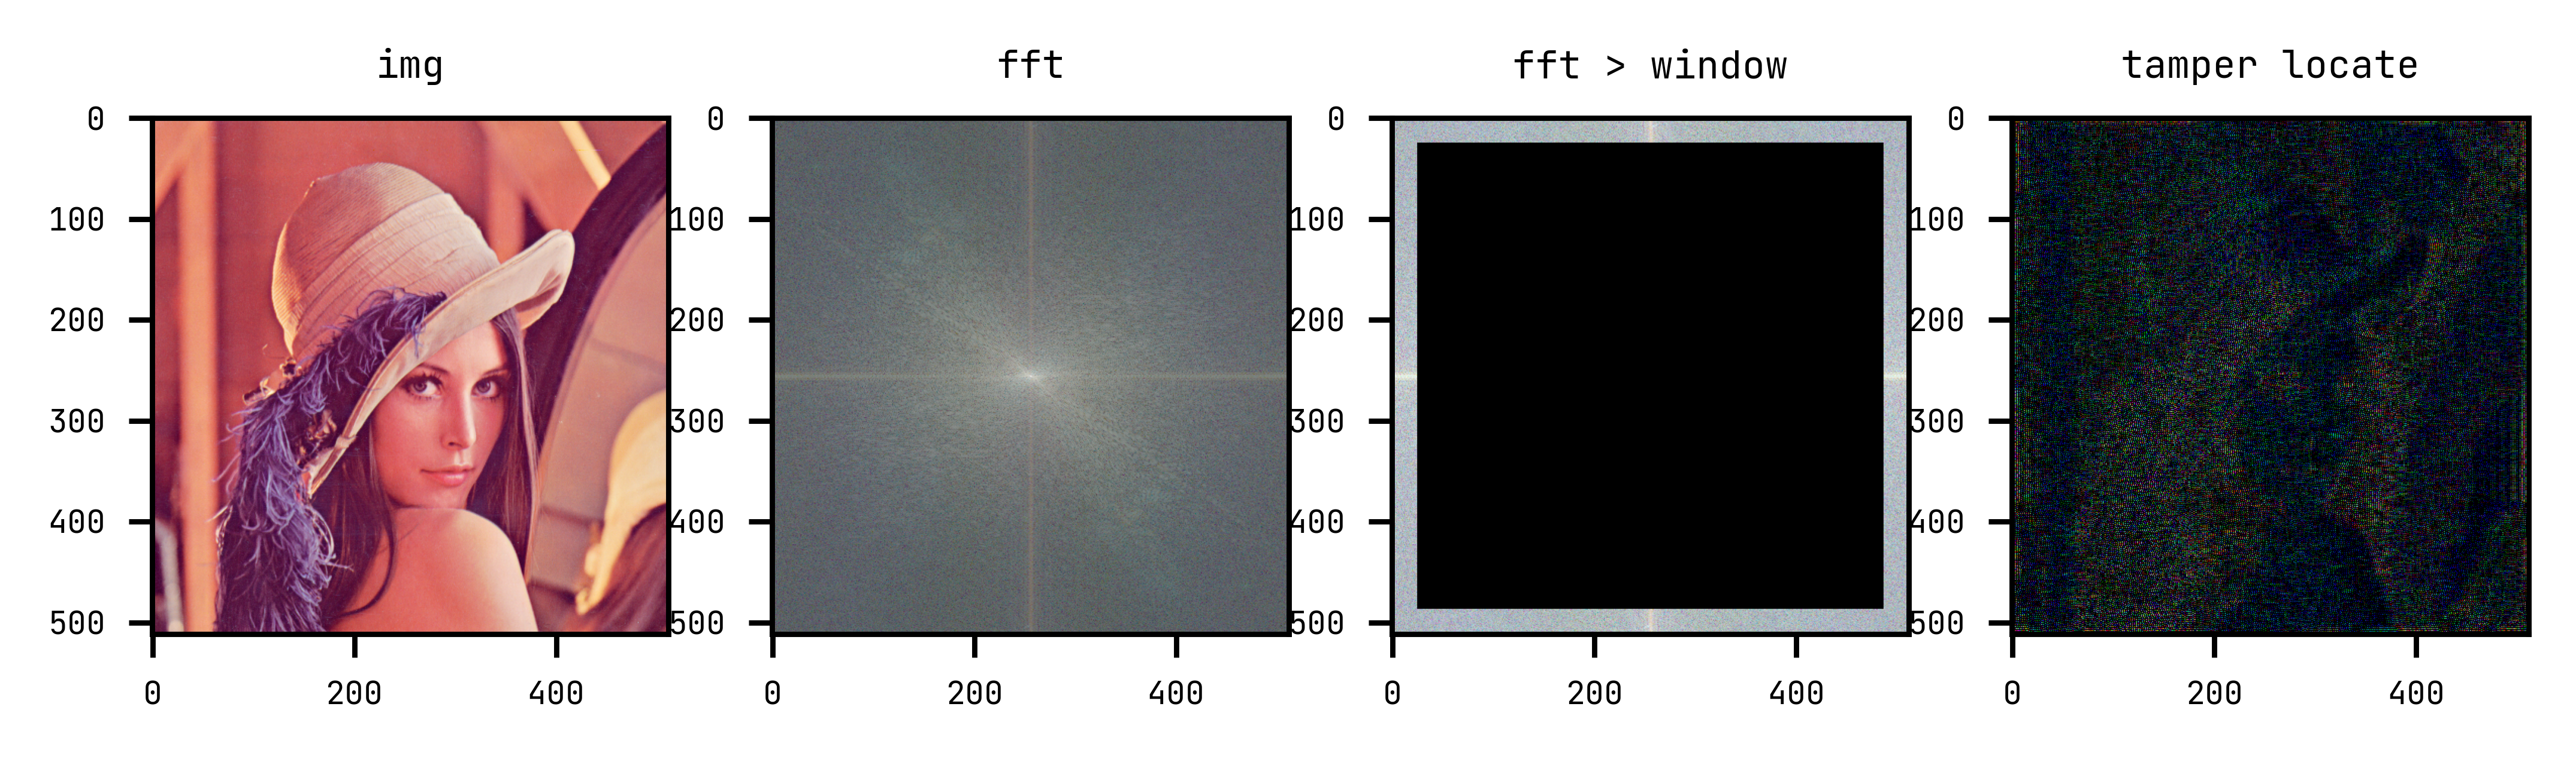

In [9]:
img_path = 'display/LenaRGB.bmp'
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_fft = rgb_fft2(img)

# 提取 CROP 范围内的频谱
crop_width = int(TAMPER_LOCATE_CROP * min(img.shape[0], img.shape[1]))
img_fft_crop = img_fft.copy()
img_fft_crop[crop_width:-crop_width, crop_width:-crop_width] = 0

# 逆变换
img_tamper_locate = rgb_ifft2(img_fft_crop) * 64

show_images([img, center_log_spectrum(img_fft), center_log_spectrum(img_fft_crop), img_tamper_locate], \
    ['img', 'fft', 'fft > window', 'tamper locate'], 1, 4, 0.4)